### Theory Questions

**a. ELBO Derivation and Why It’s Used in VAEs**

In Variational Autoencoders (VAEs), we aim to maximize the marginal likelihood of the data:

$$
\log p(x) = \log \int p(x, z) \, dz
$$

This integral is typically **intractable**, so we introduce a variational distribution $q(z|x)$ to approximate the true posterior $p(z|x)$. This leads to the **Evidence Lower Bound (ELBO)**:

$$
\log p(x) \geq \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{\text{KL}}(q(z|x) \parallel p(z))
$$

This is the **ELBO**, and maximizing it allows us to indirectly maximize $\log p(x)$.


**ELBO Breakdown**

- $\mathbb{E}_{q(z|x)}[\log p(x|z)]$: **Reconstruction log-likelihood** — measures how well the decoder reconstructs the input from latent code.
- $D_{\text{KL}}(q(z|x) \parallel p(z))$: **KL Divergence** — regularizes the encoder to keep the approximate posterior close to the prior $p(z)$ (usually $\mathcal{N}(0, I)$).

Thus, the VAE loss we minimize is:

$$
\mathcal{L}_{\text{VAE}} =
\underbrace{-\mathbb{E}_{q(z|x)}[\log p(x|z)]}_{\text{Reconstruction Loss}}
+
\underbrace{D_{\text{KL}}(q(z|x) \parallel p(z))}_{\text{Regularization Term}}
$$

**Why ELBO is Used in VAEs**

- **Tractable Optimization**: Enables optimization using gradient descent via sampling and reparameterization.
- **Latent Space Regularization**: Prevents overfitting and encourages a continuous, structured latent space.
- **Smooth Generation**: Enables interpolation and sampling of novel data points from the latent space.


---

**b. Explanation of GAN Losses**

In a Generative Adversarial Network (GAN), we have two competing models:

- **Generator (G)**: Learns to generate realistic images.
- **Discriminator (D)**: Learns to distinguish real images from fake (generated) ones.

---

**Discriminator Loss (real vs. fake classification):**

The discriminator is trained to assign high probabilities to real images and low probabilities to generated (fake) ones. The loss function is:

$$
\mathcal{L}_D = -\mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

- The first term encourages **real images** to be classified as real (i.e., $D(x) \to 1$).
- The second term encourages **fake images** to be classified as fake (i.e., $D(G(z)) \to 0$).

---

**Generator Loss (fool the discriminator):**

The generator aims to produce samples that the discriminator classifies as real. A commonly used version of the generator loss is the *non-saturating* loss:

$$
\mathcal{L}_G = -\mathbb{E}_{z \sim p_z}[\log D(G(z))]
$$

- It tries to **maximize the discriminator's belief** that fake samples are real.

This form provides **stronger gradients** during early training compared to the original minimax formulation:

$$
\mathcal{L}_G = \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

which can suffer from **vanishing gradients** when the discriminator is too strong.



### Import

In [3]:
import os
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import torchvision.utils as vutils

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random
from torch.autograd import Function

### Generative Model of the Variational AutoEncoder

Goal: Learn a compact, continuous latent representation of images, enabling generation new digits by sampling latent vectors.

Tasks:

- Train a VAE with a 2D latent vector.

- Visualize how different digits cluster in latent space by plotting latent codes colored by digit label.

- Generate new digits by sampling points on a 15x15 grid in the 2D latent space and decoding them.

- Analyze what the latent space and generated digits reveal about the model's understanding.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [ ]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True
                          num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True
                         num_workers=4, pin_memory=True)

In [ ]:
images, labels = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(images[:128], nrow=16, padding=5)

plt.figure(figsize=(12, 8))
plt.imshow(img_grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.title('MNIST Batch Samples')
plt.show()

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 2)
        self.fc_logvar = nn.Linear(400, 2)

        self.fc2 = nn.Linear(2, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)   # Return mean and log variance for latent distribution

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)             # Convert log variance to standard deviation
        eps = torch.randn_like(std)                # Sample epsilon from standard normal distribution ε ~ N(0, 1)
        return mu + eps * std                       # Reparameterization trick: z = μ + ε * σ

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        x = x.view(-1, 28*28)
        mu, logvar = self.encode(x)                # Get latent mean and log variance from encoder
        z = self.reparameterize(mu, logvar)        # Sample latent vector using reparameterization trick
        recon = self.decode(z)                      # Reconstruct image from latent vector using decoder
        return recon, mu, logvar                    # Return reconstruction and latent parameters

In [ ]:
def elbo_loss(recon_x, x, mu, logvar):
    # Reconstruction Loss (Binary Cross Entropy)
    # Measures how well the decoder reconstructs the input image.
    # recon_x: reconstructed image (output of the decoder)
    # x: original input image (flattened)
    # reduction='sum' sums over all pixels and batch elements.
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    # KL Divergence (Kullback-Leibler Divergence)
    # Measures how much the learned latent distribution (N(mu, sigma^2))
    # differs from the prior distribution (standard normal N(0,1)).
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # ELBO loss = Reconstruction loss + KL divergence
    # Minimizing this encourages both good reconstruction and
    # a latent distribution close to standard normal.
    return recon_loss + kl_loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 100
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss = elbo_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = elbo_loss(recon, x, mu, logvar)
            val_loss += loss.item()
    val_loss /= len(test_loader.dataset)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time = time.time()
print(f"Training took {(end_time - start_time):.2f} seconds")

Epoch 1, Train Loss: 189.5211, Val Loss: 170.2121
Epoch 2, Train Loss: 167.4905, Val Loss: 164.4353
Epoch 3, Train Loss: 163.6443, Val Loss: 161.9083
Epoch 4, Train Loss: 161.5315, Val Loss: 160.6319
Epoch 5, Train Loss: 159.8124, Val Loss: 158.9873
Epoch 6, Train Loss: 158.3086, Val Loss: 157.9712
Epoch 7, Train Loss: 157.1680, Val Loss: 156.9690
Epoch 8, Train Loss: 156.2117, Val Loss: 155.9391
Epoch 9, Train Loss: 155.2949, Val Loss: 155.2813
Epoch 10, Train Loss: 154.6074, Val Loss: 154.6783
Epoch 11, Train Loss: 153.9778, Val Loss: 154.2649
Epoch 12, Train Loss: 153.3237, Val Loss: 153.9400
Epoch 13, Train Loss: 152.8554, Val Loss: 153.4912
Epoch 14, Train Loss: 152.3928, Val Loss: 153.0597
Epoch 15, Train Loss: 151.8966, Val Loss: 152.9427
Epoch 16, Train Loss: 151.5066, Val Loss: 152.6504
Epoch 17, Train Loss: 151.1840, Val Loss: 152.1157
Epoch 18, Train Loss: 150.8019, Val Loss: 152.1635
Epoch 19, Train Loss: 150.4797, Val Loss: 152.3258
Epoch 20, Train Loss: 150.1754, Val Loss

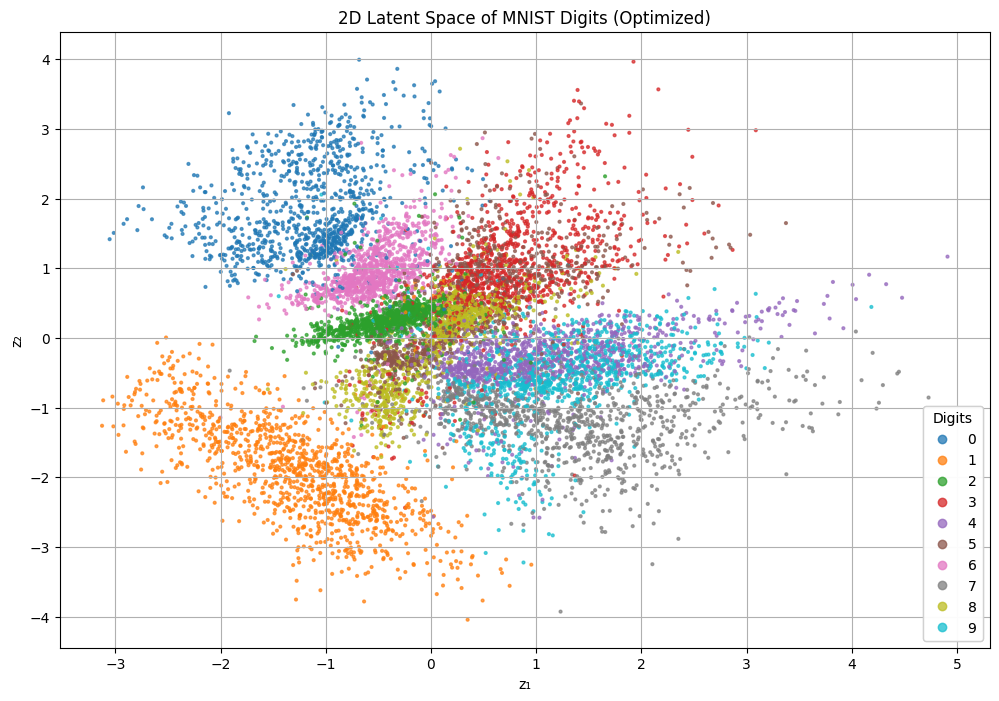

In [ ]:
model.eval()
latents = []
labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 784))
        latents.append(mu.cpu())
        labels.append(label)

latent_vectors = torch.cat(latents).numpy()
digits_labels = torch.cat(labels).numpy()


plt.figure(figsize=(12, 8))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1],
                     c=digits_labels, cmap='tab10', alpha=0.7, s=4)
legend = plt.legend(*scatter.legend_elements(), title="Digits", loc="best")
plt.gca().add_artist(legend)
plt.title("2D Latent Space of MNIST Digits (Optimized)")
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.grid(True)
plt.show()

In [ ]:
def plot_latent_grid(model, n=15, figsize=(12, 10), range=(-3, 3)):
    grid = np.linspace(range[0], range[1], n)
    digit_size = 28
    image = np.zeros((n * digit_size, n * digit_size))

    model.eval()
    with torch.no_grad():
        for i, yi in enumerate(reversed(grid)):
            for j, xi in enumerate(grid):
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                digit = model.decode(z).cpu().reshape(digit_size, digit_size).numpy()
                image[i*digit_size:(i+1)*digit_size,
                     j*digit_size:(j+1)*digit_size] = digit

    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray', extent=[*range, *range])
    plt.xlabel('z₁')
    plt.ylabel('z₂')
    plt.title(f'{n}×{n} Generated Digits from Latent Space')
    plt.axis('on')
    plt.show()

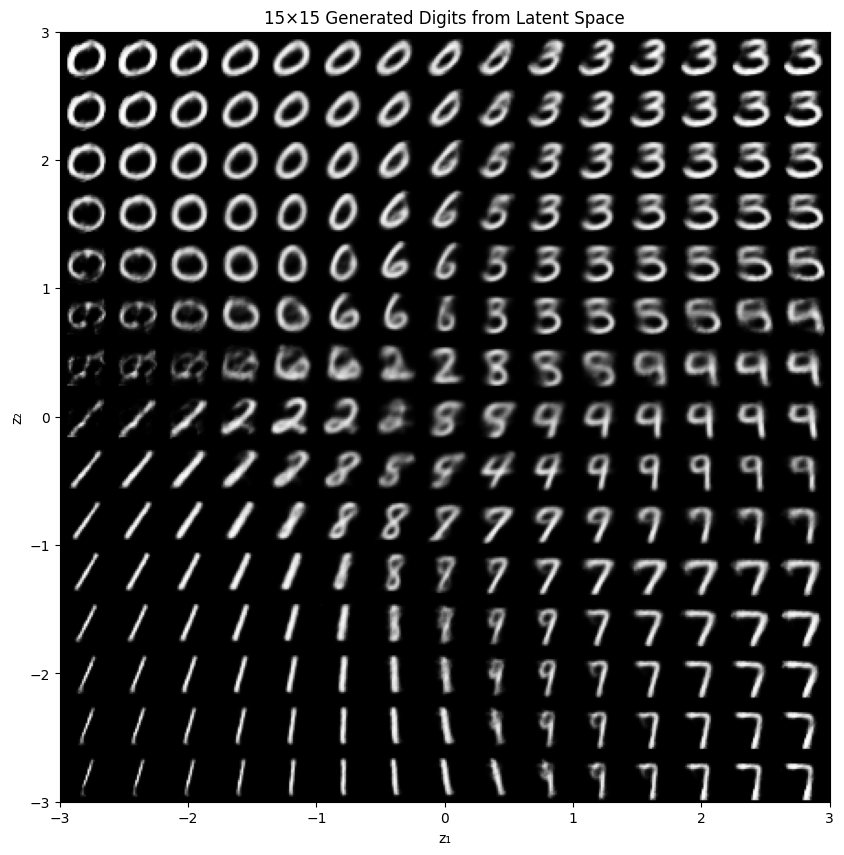

In [ ]:
plot_latent_grid(model)

The **latent space plot** shows that different digits are **clustered** in different regions of the 2D space.

The 15x15 mesh plot reveals:

- The **decoder learns a smooth mapping** from latent vectors to digits.

- Transitions between digits are continuous, showing the model's ability to generalize.

- The **edges of the space** tends to produce clearer digits, while the center may generate ambiguous samples.

### Supervised Generative Model of VAE

Goal: Condition the generation on digit labels, allowing control over which digit is generated.

Modifications:

- Use a 1D latent vector.

- Decoder input is concatenation of latent vector and one-hot digit label.

Tasks:

- Train this conditional VAE.

- Create a grid combining latent points and digit labels, generate digits, and analyze the effect of label conditioning on generation.



In [ ]:
class SupervisedVAE(nn.Module):
    def __init__(self, latent_dim=1, label_dim=10):
        super().__init__()

        # Encoder (returns 1D latent vector)
        self.encoder = nn.Sequential(
            nn.Linear(784 + label_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder (takes latent + label)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # Concatenate image and label
        h = torch.cat([x, y], dim=1)
        h = self.encoder(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # Concatenate latent code and label
        h = torch.cat([z, y], dim=1)
        return self.decoder(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 784), y)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, y)
        return recon, mu, logvar

In [ ]:
def to_onehot(y, num_classes=10):
    return torch.eye(num_classes)[y].to(device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SupervisedVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = 0
    for data, labels in train_loader:
        data, labels = data.to(device), to_onehot(labels)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = elbo_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Loss: 176.7136
Epoch 2, Loss: 153.8145
Epoch 3, Loss: 149.5695
Epoch 4, Loss: 147.7200
Epoch 5, Loss: 146.6478
Epoch 6, Loss: 145.9142
Epoch 7, Loss: 145.3242
Epoch 8, Loss: 144.7756
Epoch 9, Loss: 144.2123
Epoch 10, Loss: 143.6668
Epoch 11, Loss: 143.4223
Epoch 12, Loss: 142.9645
Epoch 13, Loss: 142.6239
Epoch 14, Loss: 142.3565
Epoch 15, Loss: 141.9164
Epoch 16, Loss: 141.7009
Epoch 17, Loss: 141.4975
Epoch 18, Loss: 141.2749
Epoch 19, Loss: 141.1607
Epoch 20, Loss: 140.9670
Epoch 21, Loss: 141.0150
Epoch 22, Loss: 140.6415
Epoch 23, Loss: 140.3907
Epoch 24, Loss: 140.1850
Epoch 25, Loss: 139.9777
Epoch 26, Loss: 140.1113
Epoch 27, Loss: 139.7149
Epoch 28, Loss: 139.5832
Epoch 29, Loss: 139.7169
Epoch 30, Loss: 139.8372
Epoch 31, Loss: 139.2360
Epoch 32, Loss: 139.1487
Epoch 33, Loss: 138.8973
Epoch 34, Loss: 138.8035
Epoch 35, Loss: 138.6310
Epoch 36, Loss: 138.6301
Epoch 37, Loss: 138.6593
Epoch 38, Loss: 138.3250
Epoch 39, Loss: 138.5391
Epoch 40, Loss: 138.4336
Epoch 41,

In [ ]:
def plot_conditional_samples_optimal(model, n_latent=15, digit_size=1):
    model.eval()

    # Create latent space grid (1D)
    latent_points = torch.linspace(-3, 3, n_latent).unsqueeze(1).to(device)  # (15,1)

    # Create one-hot labels for all digits
    onehot_labels = torch.eye(10).to(device)  # (10,10)

    # Generate all images in one batch for efficiency
    with torch.no_grad():
        # Create input tensors: (n_latent*10, 1) latent codes and (n_latent*10, 10) labels
        z = latent_points.repeat_interleave(10, dim=0)  # (150,1)
        y = onehot_labels.repeat(n_latent, 1)  # (150,10)

        # Decode all at once
        reconstructions = model.decode(z, y).cpu()  # (150,784)
        images = reconstructions.view(-1, 28, 28).numpy()  # (150,28,28)

    # Calculate figure size based on desired digit size
    fig_width = 10 * digit_size
    fig_height = n_latent * digit_size * 0.8  # Slightly shorter rows

    # Create figure with optimal layout
    plt.figure(figsize=(fig_width, fig_height))

    # Plot with annotations
    for i in range(n_latent):
        for j in range(10):
            # Calculate position in grid
            ax = plt.subplot2grid((n_latent, 10), (i, j))

            # Display image
            idx = i * 10 + j
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')

            # Add latent value on leftmost column
            if j == 0:
                z_val = latent_points[i].item()
                ax.set_ylabel(f'z={z_val:.1f}', rotation=0,
                            ha='right', va='center', fontsize=10)  # Increased font

            # Add digit label on top row
            if i == 0:
                ax.set_title(str(j), pad=4, fontsize=12)  # Increased font and padding

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)  # Adjust spacing
    plt.suptitle('Supervised VAE: Latent Space Traversal × Digit Conditions',
                y=1.02, fontsize=14)
    plt.show()

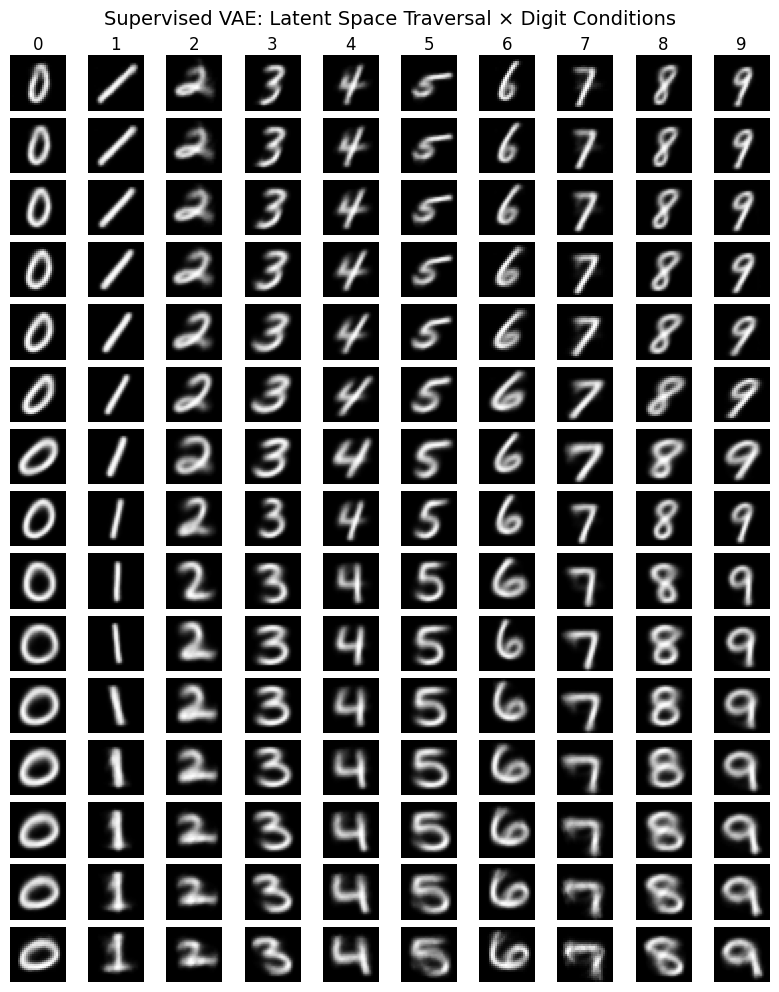

In [ ]:
plot_conditional_samples_optimal(model, digit_size=0.8)

### Generative Adversarial Network

Goal: Train a generator to produce realistic digits by fooling a discriminator that distinguishes real/fake images.

Tasks:

- Implement generator taking a 2D latent vector.

- Implement discriminator to classify real vs fake.

- Train GAN and track generator and discriminator losses to observe adversarial training dynamics.

- Visualize generator outputs on a 15x15 latent space grid.

- Analyze what these generated images and losses indicate about training quality and model behavior.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128), # Input: 2D noise vector
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()  # Output in [-1,1] range
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Probability of being real
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)
G_optim = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optim = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

n_epochs = 100
G_losses = []
D_losses = []

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1] range
])

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
for epoch in range(n_epochs):
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0

    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Adversarial labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        # 1. Train Discriminator
        # ---------------------
        D_optim.zero_grad()

        # Real images
        real_output = D(real_imgs)
        D_loss_real = criterion(real_output, real_labels)

        # Fake images
        z = torch.randn(batch_size, 2).to(device)
        fake_imgs = G(z).detach()  # Detach to avoid training G here
        fake_output = D(fake_imgs)
        D_loss_fake = criterion(fake_output, fake_labels)

        # Combined loss
        D_loss = (D_loss_real + D_loss_fake) / 2  # Average
        D_loss.backward()
        D_optim.step()
        epoch_loss_D += D_loss.item()

        # -----------------
        # 2. Train Generator
        # -----------------
        G_optim.zero_grad()

        # Generate new fake images
        z = torch.randn(batch_size, 2).to(device)
        gen_imgs = G(z)

        # Try to fool D
        output = D(gen_imgs)
        G_loss = criterion(output, real_labels)
        G_loss.backward()
        G_optim.step()
        epoch_loss_G += G_loss.item()

    # Store epoch averages
    avg_G_loss = epoch_loss_G / len(train_loader)
    avg_D_loss = epoch_loss_D / len(train_loader)
    G_losses.append(avg_G_loss)
    D_losses.append(avg_D_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")

Epoch 1/100 | D Loss: 0.5413 | G Loss: 1.0850
Epoch 2/100 | D Loss: 0.4432 | G Loss: 1.8424
Epoch 3/100 | D Loss: 0.4055 | G Loss: 2.1634
Epoch 4/100 | D Loss: 0.3417 | G Loss: 2.4366
Epoch 5/100 | D Loss: 0.3482 | G Loss: 2.5094
Epoch 6/100 | D Loss: 0.2927 | G Loss: 2.9080
Epoch 7/100 | D Loss: 0.2491 | G Loss: 3.1698
Epoch 8/100 | D Loss: 0.2205 | G Loss: 3.1466
Epoch 9/100 | D Loss: 0.1939 | G Loss: 3.2592
Epoch 10/100 | D Loss: 0.1693 | G Loss: 3.8213
Epoch 11/100 | D Loss: 0.1685 | G Loss: 3.8264
Epoch 12/100 | D Loss: 0.1816 | G Loss: 3.7703
Epoch 13/100 | D Loss: 0.1813 | G Loss: 3.2167
Epoch 14/100 | D Loss: 0.2085 | G Loss: 3.2217
Epoch 15/100 | D Loss: 0.2330 | G Loss: 2.9037
Epoch 16/100 | D Loss: 0.2400 | G Loss: 2.8589
Epoch 17/100 | D Loss: 0.2424 | G Loss: 2.7933
Epoch 18/100 | D Loss: 0.2336 | G Loss: 2.6859
Epoch 19/100 | D Loss: 0.2546 | G Loss: 2.6662
Epoch 20/100 | D Loss: 0.2479 | G Loss: 2.6901
Epoch 21/100 | D Loss: 0.2570 | G Loss: 2.5951
Epoch 22/100 | D Loss:

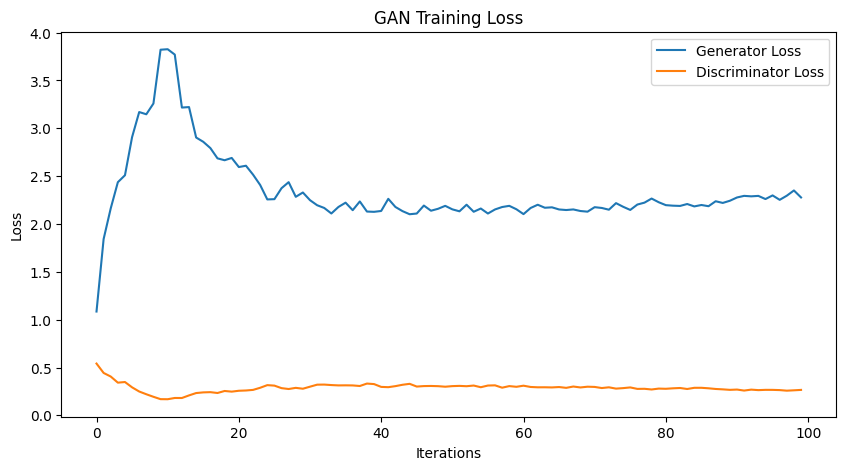

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')
plt.show()

- The discriminator loss decreases, suggesting it’s getting confused and predicting values close to 0.5 for both real and fake.

- The generator loss increases, but this is actually a good sign in GANs — it means the generator is successfully fooling the discriminator into believing fakes are real.

- By the final epochs, the generator is “winning”, as it’s generating samples realistic enough that the discriminator struggles to distinguish them.

In [55]:
def visualize_latent_space_2d(generator, n=15, device='cpu', title='Generated Digits from 2D Latent Space'):
    # Create a grid of points in the 2D latent space
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)
    mesh_latents = torch.tensor([[xi, yi] for yi in reversed(grid_y) for xi in grid_x], dtype=torch.float32).to(device)

    # Generate images from the latent space grid
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(mesh_latents).cpu().view(-1, 28, 28)
        gen_imgs = (gen_imgs + 1) / 2  # Rescale from [-1, 1] to [0, 1] for visualization

    # Stitch images into a single canvas (n x n grid)
    rows = []
    for i in range(n):
        row = torch.hstack([gen_imgs[i * n + j] for j in range(n)])
        rows.append(row)
    canvas = torch.vstack(rows).numpy()

    # Display the canvas
    plt.figure(figsize=(12, 12))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

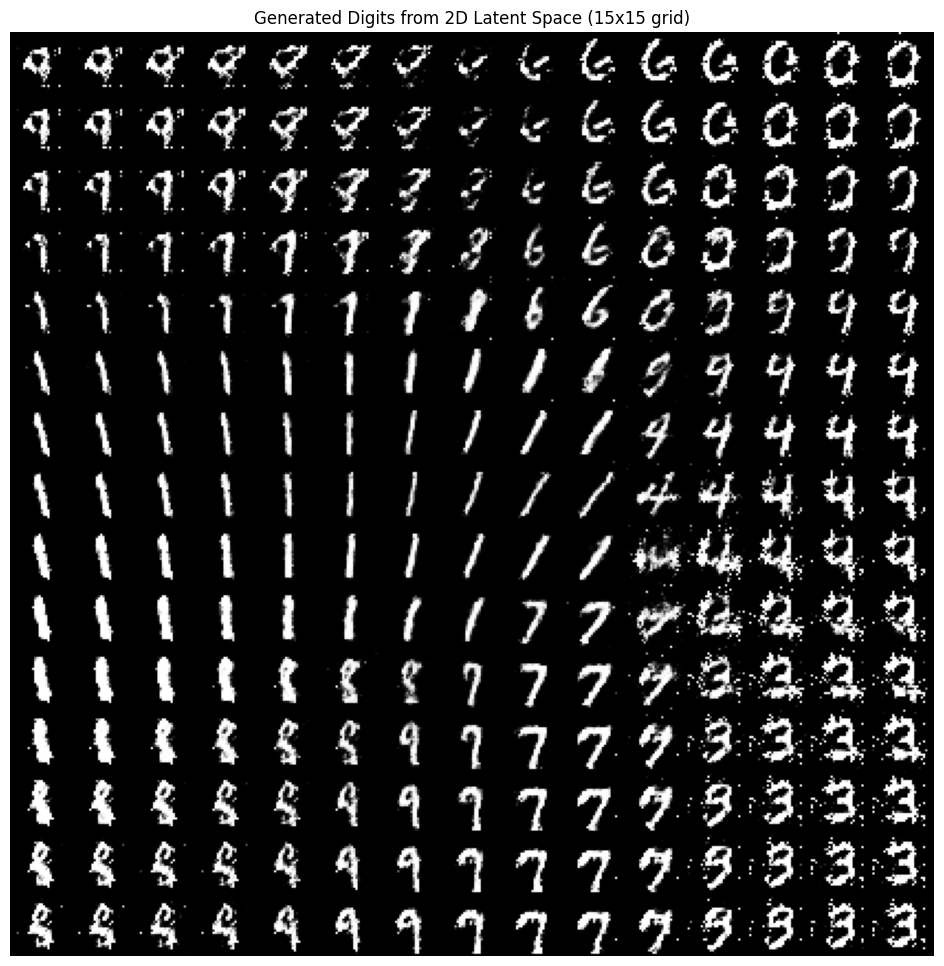

In [ ]:
visualize_latent_space_2d(G, n=15, device=device)

The latent space smoothly maps to different digit styles or digit classes.

Nearby points generate visually similar digits.

Some grid regions may generate blurry or unrealistic digits if those latent vectors are less explored by the generator.

The GAN learns to produce realistic handwritten digits from simple 2D noise.

Unlike VAEs, GAN outputs tend to be sharper but may lack explicit latent-space regularity.

### Gradient Reversal

What: A special layer that multiplies gradients by a negative scalar during backpropagation, effectively reversing gradient direction.

Why: It enables training adversarially with a single backward pass, often used in domain adaptation and to combine generator/discriminator training steps efficiently.

Task: Replace separate discriminator-generator updates with one update using GRL and achieve similar quality.

**What is a Gradient Reversal Layer (GRL)?**

A Gradient Reversal Layer is a custom operation used during training that:

- Acts as the identity function in the forward pass: `GRL(x) = x`
- Reverses and optionally scales the gradient in the backward pass: `∂L/∂x = -λ * ∂L/∂x`

This effectively turns a minimization problem into a maximization one for the upstream layers, allowing adversarial objectives to be incorporated directly.

**Why is it useful in GANs?**

Instead of doing two separate backward passes (one for D, one for G), you can perform a single forward + backward pass, with GRL applied only during the generator update to reverse gradients flowing from the discriminator.


- The GRL allows a single network to learn representations that are simultaneously useful for one task but invariant to another adversarial task.

- Originally introduced in Domain-Adversarial Neural Networks (DANN) for domain adaptation, it encourages the learned features to confuse a domain classifier by reversing gradients from that classifier during backprop.

- In GANs or other adversarial setups, GRL can be used to train a generator and discriminator with a single backward pass, simplifying the training loop.

- It helps integrate adversarial objectives into a single network end-to-end without explicit alternating optimization steps.


**What does GRL enable?**

- A shared encoder or generator can learn features that **confuse another network** (e.g., a discriminator or domain classifier).

- **Simultaneous training** of opposing objectives in **one backward pass** instead of two separate updates.

**Key Benefit**

The GRL **removes the need for manual dual-step optimization** by letting gradients flow backward normally for one task, while reversing them for the adversarial task — all within a single unified computation graph.



In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

In [45]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()  # Output range [-1,1]
        )
    def forward(self, z):
        return self.net(z)

In [46]:
class DiscriminatorWithGRL(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
        self.feature_extractor = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
        )
        self.classifier = nn.Linear(256, 1)

    def forward(self, x, use_grl=False):
        x = x.view(x.size(0), -1)
        features = self.feature_extractor(x)
        if use_grl:
            features = grad_reverse(features, self.lambda_)
        out = self.classifier(features)
        return out

In [51]:
latent_dim = 100
batch_size = 128
lr = 2e-4
n_epochs = 20
lambda_ = 1.0     # Gradient reversal strength

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.view(-1))
])

dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                    num_workers=2, pin_memory=True)

G = Generator(latent_dim).to(device)
D = DiscriminatorWithGRL(lambda_).to(device)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

G.apply(weights_init)
D.apply(weights_init)

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

G_losses, D_losses = [], []

In [52]:
try:
    for epoch in range(1, n_epochs + 1):
        g_loss, d_loss = 0, 0
        for real_imgs, _ in loader:
            bs = real_imgs.size(0)
            real_imgs = real_imgs.to(device).view(bs, -1)

            real_labels = torch.ones(bs, 1, device=device)
            fake_labels = torch.zeros(bs, 1, device=device)

            # Train Discriminator
            z = torch.randn(bs, latent_dim, device=device)
            fake_imgs = G(z).detach()

            D_real = D(real_imgs)
            D_fake = D(fake_imgs)

            loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            # Train Generator
            z = torch.randn(bs, latent_dim, device=device)
            gen_imgs = G(z)
            D_pred = D(gen_imgs)

            loss_G = criterion(D_pred, real_labels)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

            d_loss += loss_D.item()
            g_loss += loss_G.item()

        G_losses.append(g_loss / len(loader))
        D_losses.append(d_loss / len(loader))
        print(f"Epoch [{epoch}/{n_epochs}] | D: {D_losses[-1]:.4f} | G: {G_losses[-1]:.4f}")

except KeyboardInterrupt:
    print("Training interrupted.")

Epoch [1/20] | D: 1.3872 | G: 0.6936
Epoch [2/20] | D: 1.3864 | G: 0.6932
Epoch [3/20] | D: 1.3863 | G: 0.6932
Epoch [4/20] | D: 1.3863 | G: 0.6932
Epoch [5/20] | D: 1.3863 | G: 0.6932
Epoch [6/20] | D: 1.3863 | G: 0.6932
Epoch [7/20] | D: 1.3863 | G: 0.6931
Epoch [8/20] | D: 1.3863 | G: 0.6931
Epoch [9/20] | D: 1.3863 | G: 0.6931
Epoch [10/20] | D: 1.3863 | G: 0.6931
Epoch [11/20] | D: 1.3863 | G: 0.6931
Epoch [12/20] | D: 1.3863 | G: 0.6931
Epoch [13/20] | D: 1.3863 | G: 0.6931
Epoch [14/20] | D: 1.3863 | G: 0.6931
Epoch [15/20] | D: 1.3863 | G: 0.6932
Epoch [16/20] | D: 1.3863 | G: 0.6931
Epoch [17/20] | D: 1.3863 | G: 0.6931
Epoch [18/20] | D: 1.3863 | G: 0.6931
Epoch [19/20] | D: 1.3863 | G: 0.6931
Epoch [20/20] | D: 1.3863 | G: 0.6931


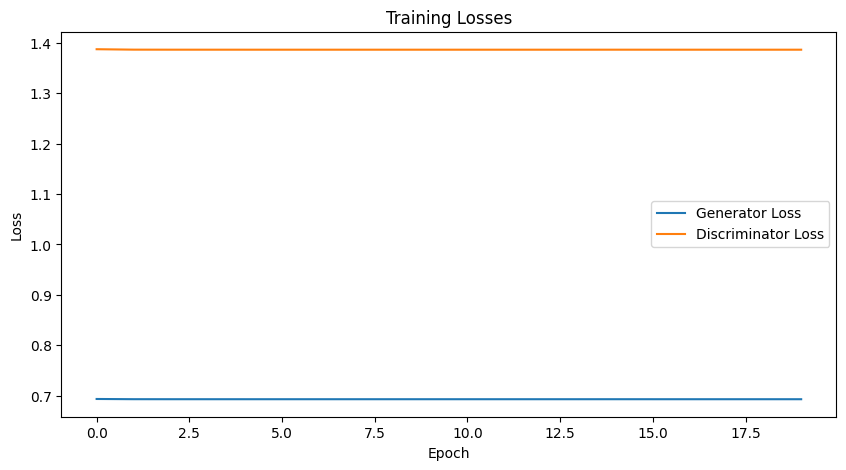

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

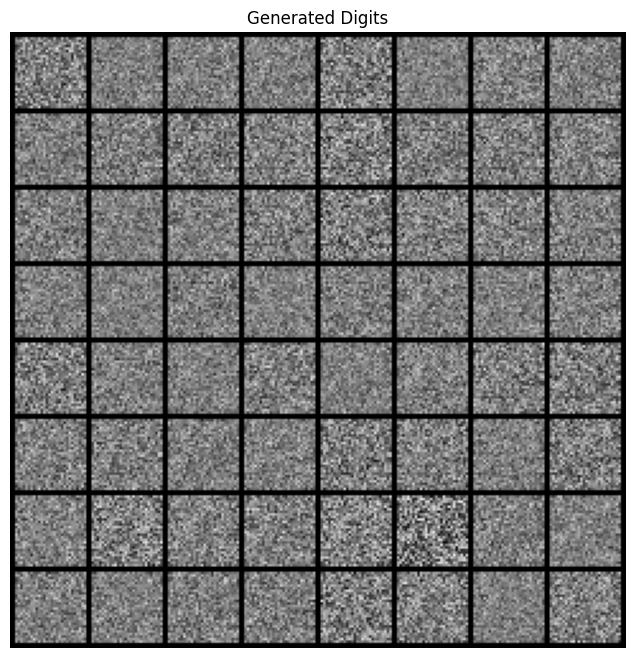

In [57]:
# Generate a batch of fake images
G.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)  # 8x8 grid
    fake_imgs = G(z).view(-1, 1, 28, 28)  # reshape for display

# Rescale from [-1, 1] to [0, 1]
fake_imgs = (fake_imgs + 1) / 2

# Show the grid of generated digits
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Digits")
plt.imshow(np.transpose(vutils.make_grid(fake_imgs.cpu(), padding=2, normalize=False), (1, 2, 0)))
plt.show()

### Supervised Generative Adversarial Network

Goal: Allow conditional generation — generate specific digits on demand.

How: Modify GAN architecture to input both latent vector and digit label (condition).

Tasks:

- Propose changes to incorporate conditioning.

- Implement and train the supervised GAN.

- Visualize generated digits for each label to verify conditioning works.

**Supervised / Conditional GAN: How to Control the Generated Digit**

To generate specific digits (e.g., 0–9) with a GAN, we can use a **Conditional GAN (cGAN)**. This setup allows us to control the output by conditioning both the **Generator** and **Discriminator** on the digit label.

---

**Generator**

- **Input**:  
  A **random noise vector** `z` (e.g., 2D) **concatenated** with a **one-hot encoded digit label** `y` (10D).  
  
  Input shape: `z + y = (2 + 10) = 12`

- **Output**:  
  A **28×28 image** that resembles the digit corresponding to label `y`.

---

**Discriminator**

- **Input**:  
  An **image** (real or generated) **concatenated** with its **one-hot label** `y`.

- **Goal**:  
  Predict whether the **(image, label)** pair is **real** (from the dataset) or **fake** (from the generator).

- **Why concatenate the label?**  
  This allows the discriminator to learn whether the image actually **matches the label**.

---
**Result**

This structure lets us **control which digit is generated**, enabling targeted synthesis of handwritten digits.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100
n_classes = 10
img_shape = (1, 28, 28)
batch_size = 128
lr = 2e-4
embed_dim = 50
n_epochs = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # -> (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),     # -> (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_emb(labels)
        x = torch.cat([z, label_embed], dim=1)
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, embed_dim)
        self.model = nn.Sequential(
            nn.Conv2d(1 + embed_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embed = self.label_emb(labels).unsqueeze(2).unsqueeze(3)  # (B, embed, 1, 1)
        label_map = label_embed.expand(-1, embed_dim, 28, 28)           # (B, embed, 28, 28)
        x = torch.cat([img, label_map], dim=1)
        return self.model(x)

In [7]:
G = Generator().to(device)
D = Discriminator().to(device)
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

losses_G, losses_D = [], []

In [8]:
for epoch in range(n_epochs):
    g_loss_sum = d_loss_sum = 0.0
    for real_imgs, labels in train_loader:
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        # === Train Discriminator ===
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = G(z, labels)

        d_real = D(real_imgs, labels)
        d_fake = D(gen_imgs.detach(), labels)

        loss_real = criterion(d_real, valid)
        loss_fake = criterion(d_fake, fake)
        d_loss = (loss_real + loss_fake) / 2

        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # === Train Generator ===
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = G(z, labels)
        g_loss = criterion(D(gen_imgs, labels), valid)

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

        g_loss_sum += g_loss.item()
        d_loss_sum += d_loss.item()

    losses_G.append(g_loss_sum / len(train_loader))
    losses_D.append(d_loss_sum / len(train_loader))

    print(f"Epoch [{epoch+1}/{n_epochs}]  D Loss: {losses_D[-1]:.4f} | G Loss: {losses_G[-1]:.4f}")

Epoch [1/100]  D Loss: 0.4148 | G Loss: 1.9171
Epoch [2/100]  D Loss: 0.5655 | G Loss: 0.9869
Epoch [3/100]  D Loss: 0.5751 | G Loss: 0.9798
Epoch [4/100]  D Loss: 0.6039 | G Loss: 0.9331
Epoch [5/100]  D Loss: 0.6222 | G Loss: 0.8940
Epoch [6/100]  D Loss: 0.6318 | G Loss: 0.8718
Epoch [7/100]  D Loss: 0.6375 | G Loss: 0.8643
Epoch [8/100]  D Loss: 0.6390 | G Loss: 0.8585
Epoch [9/100]  D Loss: 0.6411 | G Loss: 0.8528
Epoch [10/100]  D Loss: 0.6429 | G Loss: 0.8510
Epoch [11/100]  D Loss: 0.6437 | G Loss: 0.8489
Epoch [12/100]  D Loss: 0.6492 | G Loss: 0.8484
Epoch [13/100]  D Loss: 0.6485 | G Loss: 0.8421
Epoch [14/100]  D Loss: 0.6468 | G Loss: 0.8463
Epoch [15/100]  D Loss: 0.6458 | G Loss: 0.8449
Epoch [16/100]  D Loss: 0.6466 | G Loss: 0.8467
Epoch [17/100]  D Loss: 0.6443 | G Loss: 0.8565
Epoch [18/100]  D Loss: 0.6408 | G Loss: 0.8588
Epoch [19/100]  D Loss: 0.6379 | G Loss: 0.8626
Epoch [20/100]  D Loss: 0.6331 | G Loss: 0.8733
Epoch [21/100]  D Loss: 0.6297 | G Loss: 0.8825
E

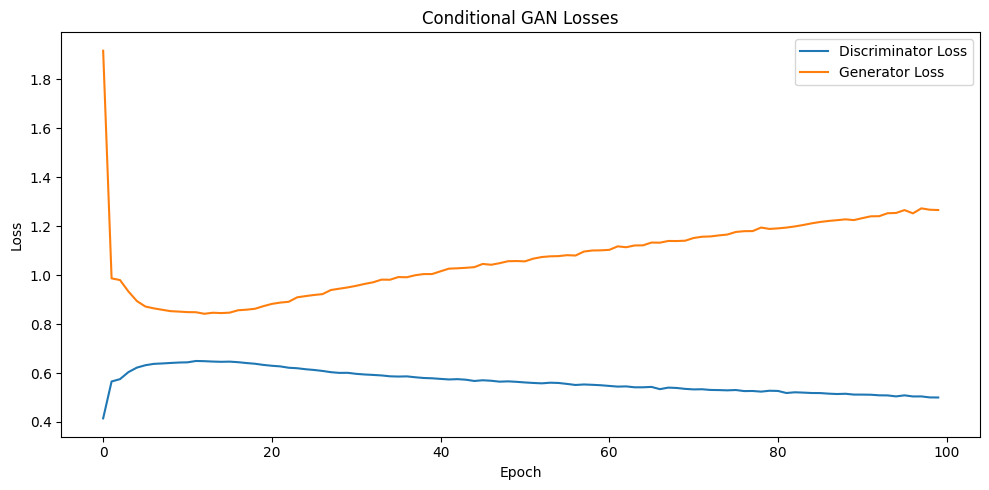

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Conditional GAN Losses")
plt.tight_layout()
plt.show()

In [26]:
@torch.no_grad()
def visualize_digit_samples(generator, latent_dim=100, n_classes=10, samples_per_class=10, device='cuda'):
    generator.eval()

    total_samples = n_classes * samples_per_class

    z = torch.randn(total_samples, latent_dim, device=device)
    labels = torch.arange(n_classes, device=device).repeat_interleave(samples_per_class)
    fake_imgs = generator(z, labels)

    grid = vutils.make_grid(fake_imgs, nrow=n_classes, normalize=True, value_range=(-1, 1))

    plt.figure(figsize=(n_classes * 1.0, samples_per_class * 1.0))
    plt.axis("off")
    plt.title(f"{samples_per_class} Samples per Digit (0–9)")
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.show()

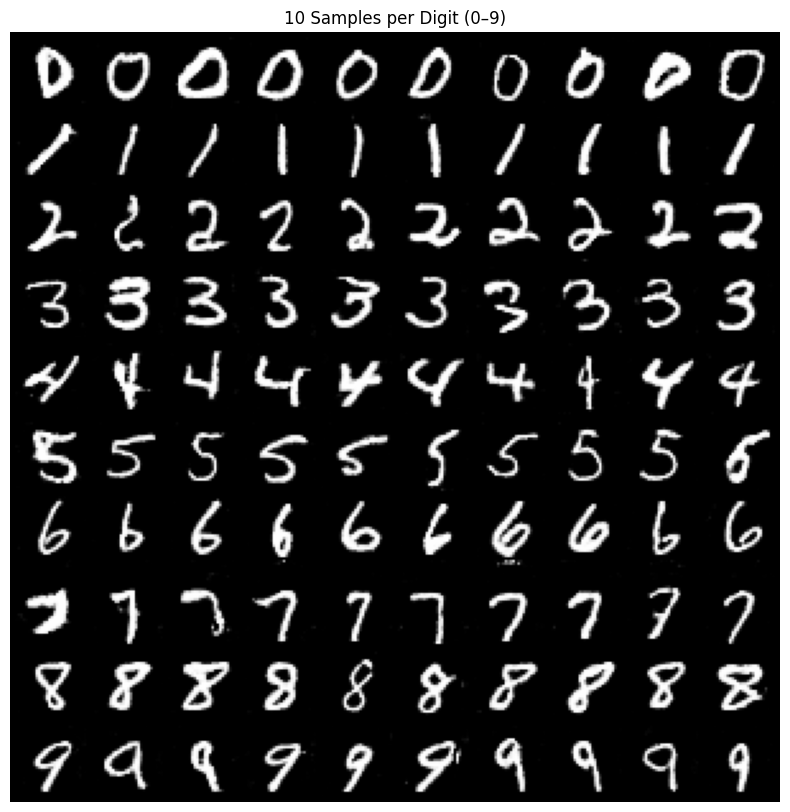

In [27]:
visualize_digit_samples(G, latent_dim=latent_dim, device=device)

- Each digit is generated from random noise + digit label.

- All digits are recognizable.

### Bonus Part

Idea: Learn to generate data by reversing a diffusion process (gradually adding noise and learning to denoise).

Task: Explore and try implementing a diffusion model on MNIST.


**Understanding Diffusion Models (DDPM)**

Diffusion models are a class of generative models that learn to generate data by reversing a gradual noising process.

---

**Core Components**

**1. Forward Process (Diffusion)**

We gradually add noise to a data sample `x_0 ` over a series of time steps until the image becomes pure Gaussian noise.

At each step `t `, we compute:

$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \cdot x_{t-1}, \beta_t \cdot I)
$$

After enough steps, $x_T \sim \mathcal{N}(0, I)$.

This is a Markov chain that simulates data destruction.

---

**2. Reverse Process (Denoising)**

The model learns to reverse the noise step by step by predicting the original data from the noisy version.

We train a neural network $\epsilon_\theta(x_t, t)$ to predict the noise added at each step.

The reverse transition is learned as:

$$
p_\theta(x_{t-1} \mid x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

Think of this as learning to "denoise" an image progressively.

---

**3. Loss Function**

We use a mean squared error (MSE) loss to train the model to predict the noise:

$$
L_{\text{simple}} = \mathbb{E}_{x_0, t, \epsilon} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

Where:

- $\epsilon \sim \mathcal{N}(0, I)$
- $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$

---

**4. Sampling**

To generate new data:

1. Sample noise $x_T \sim \mathcal{N}(0, I)$
2. Apply the learned denoising steps backwards from $T \to 0 $

Output is a generated image $x_0$

---

**Summary**

| Step     | Description                       |
| -------- | --------------------------------- |
| Forward  | Adds noise step-by-step (data → noise) |
| Reverse  | Learns to remove noise (noise → data) |
| Loss     | MSE between true and predicted noise |
| Sampling | Start from noise, denoise with the model |

---

Diffusion models like DDPM and Stable Diffusion have shown state-of-the-art results in image generation and are now widely used in AI art, video synthesis, and more.
